In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Exploring data

In [2]:
df=pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [3]:
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Name       object
dtype: object

## Converting date to datetime type and setting it as index

In [4]:
df=df.set_index('Date')
df.index=pd.to_datetime(df.index, format='%Y-%m-%d')

In [5]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [6]:
df.index

DatetimeIndex(['2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06',
               '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12',
               '2006-01-13', '2006-01-17',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=3019, freq=None)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
Open      3019 non-null float64
High      3019 non-null float64
Low       3019 non-null float64
Close     3019 non-null float64
Volume    3019 non-null int64
Name      3019 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


## Creating time series of close

In [8]:
ts_org=df['Close']

In [9]:
ts_org.head()

Date
2006-01-03    217.83
2006-01-04    222.84
2006-01-05    225.85
2006-01-06    233.06
2006-01-09    233.68
Name: Close, dtype: float64

In [10]:
ts=ts_org.resample('D').bfill()

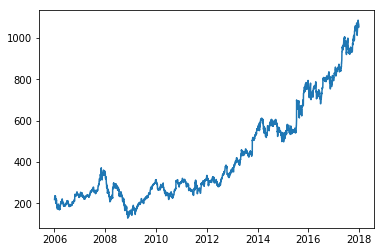

In [11]:
plt.plot(ts)

## Detecting seasonality

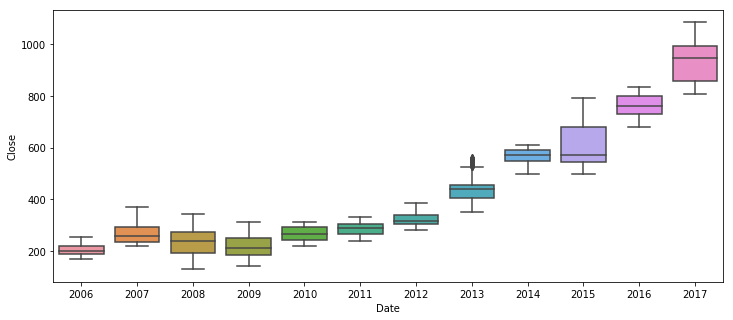

In [12]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(ts.index.year, ts, ax=ax)

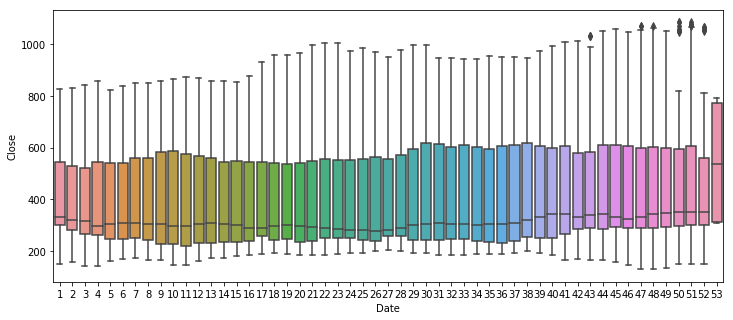

In [13]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(ts.index.week, ts, ax=ax)

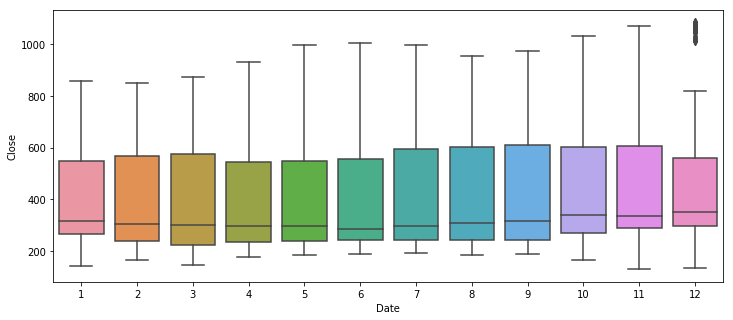

In [14]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(ts.index.month, ts, ax=ax)

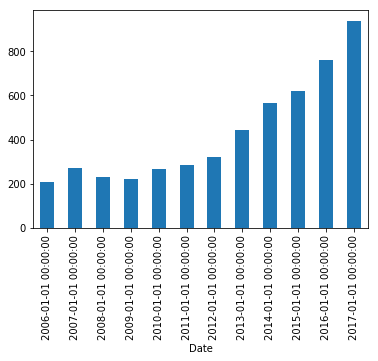

In [15]:
ts.resample('AS').mean().plot.bar()

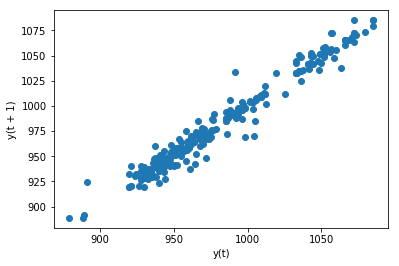

In [16]:
from pandas.plotting import lag_plot

lag_plot(ts.tail(250))

# Testing stationarity

In [17]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=365).mean()
    rolstd = pd.Series.rolling(timeseries, window=365).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    print ('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

/home/ibtissem/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


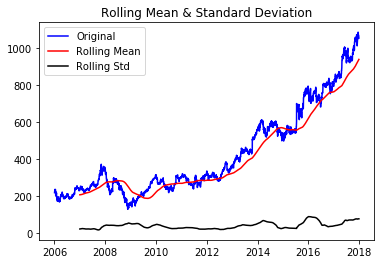

Results of Dickey-Fuller Test:
Test Statistic                    1.174126
p-value                           0.995802
#Lags Used                        5.000000
Number of Observations Used    4373.000000
Critical Value (1%)              -3.431846
Critical Value (5%)              -2.862201
Critical Value (10%)             -2.567122
dtype: float64


In [18]:
test_stationarity(ts)

# Transforming our non stationary series into stationary series

## Log transform (to eliminate the exponential growth)

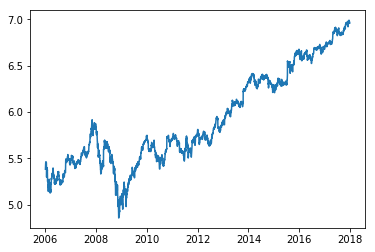

In [19]:
ts_log = np.log(ts)
plt.plot(ts_log)

## Trying different methods

### Moving average

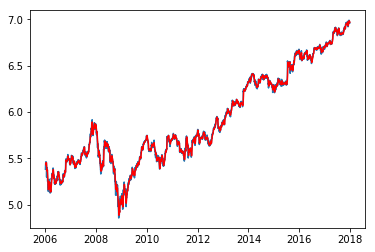

In [20]:
moving_avg = pd.Series.rolling(ts_log,7).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [21]:
ts_log_moving_avg_diff = ts_log - moving_avg
#ts_log_moving_avg_diff.head(30)

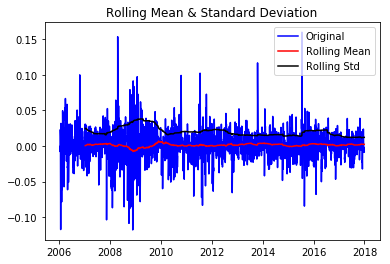

Results of Dickey-Fuller Test:
Test Statistic                -1.143297e+01
p-value                        6.449183e-21
#Lags Used                     2.800000e+01
Number of Observations Used    4.344000e+03
Critical Value (1%)           -3.431856e+00
Critical Value (5%)           -2.862206e+00
Critical Value (10%)          -2.567124e+00
dtype: float64


In [22]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

### Exponentially weighted moving average

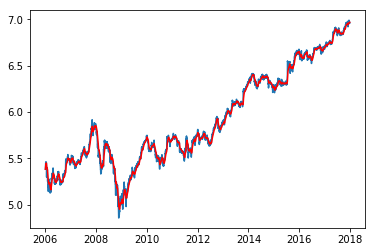

In [23]:
expwighted_avg = ts_log.ewm(halflife=7).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

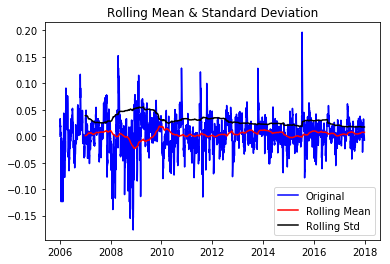

Results of Dickey-Fuller Test:
Test Statistic                -9.507648e+00
p-value                        3.314036e-16
#Lags Used                     2.800000e+01
Number of Observations Used    4.350000e+03
Critical Value (1%)           -3.431854e+00
Critical Value (5%)           -2.862205e+00
Critical Value (10%)          -2.567124e+00
dtype: float64


In [24]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

### Differencing

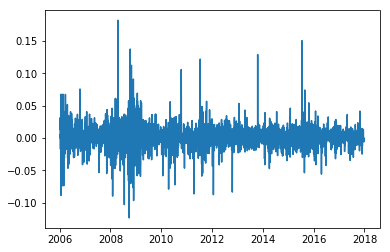

In [25]:
ts_log_diff = ts_log.diff()
plt.plot(ts_log_diff)

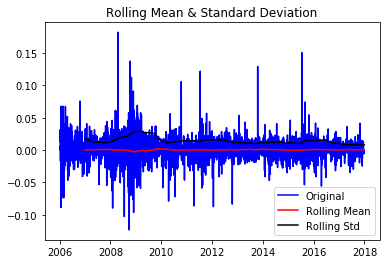

Results of Dickey-Fuller Test:
Test Statistic                -1.189270e+01
p-value                        5.817964e-22
#Lags Used                     2.700000e+01
Number of Observations Used    4.350000e+03
Critical Value (1%)           -3.431854e+00
Critical Value (5%)           -2.862205e+00
Critical Value (10%)          -2.567124e+00
dtype: float64


In [26]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Decomposition

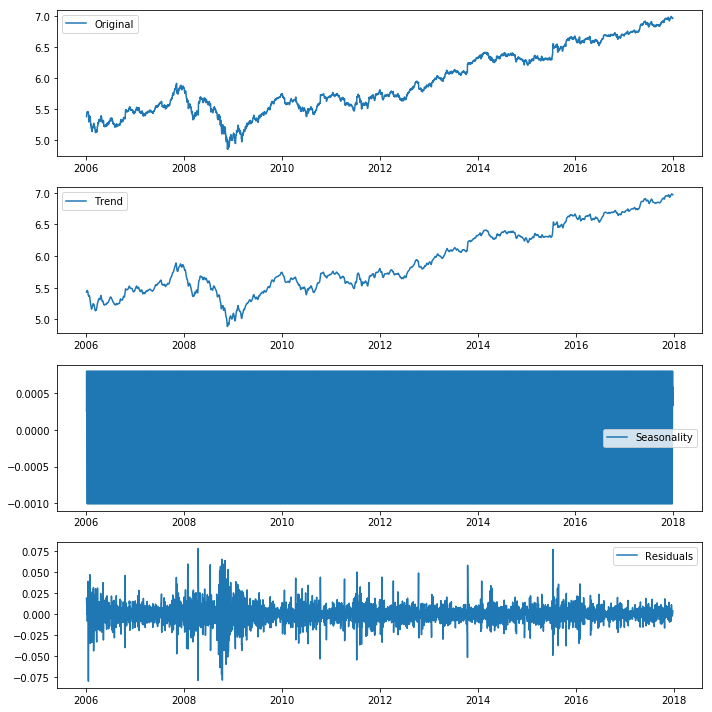

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

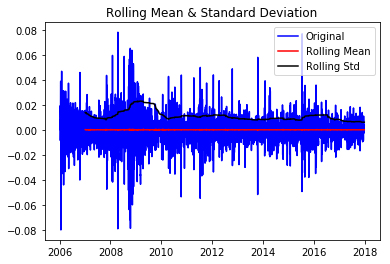

Results of Dickey-Fuller Test:
Test Statistic                  -20.760771
p-value                           0.000000
#Lags Used                       28.000000
Number of Observations Used    4344.000000
Critical Value (1%)              -3.431856
Critical Value (5%)              -2.862206
Critical Value (10%)             -2.567124
dtype: float64


In [28]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# ARIMA model (using decomposition method to transfor series)

In [29]:
train, cv, test=ts_log_decompose['2006':'2013'], ts_log_decompose['2014':'2015'], ts_log_decompose['2016':'2017']

In [30]:
#from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## ACF plot (to identify the order of the MA model)

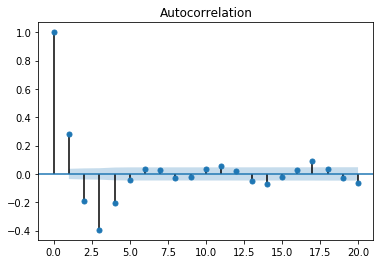

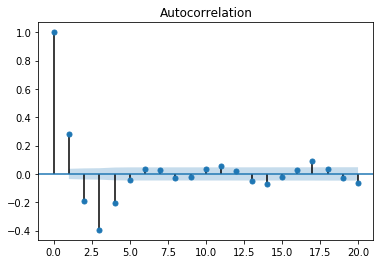

In [31]:
plot_acf(train, lags=20, alpha=0.05)

## PACF plot (to identify the order of AR model)

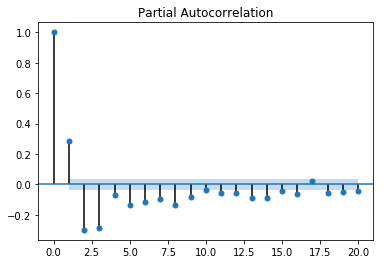

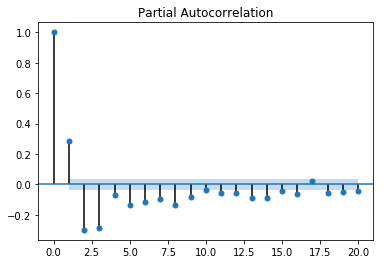

In [32]:
plot_pacf(train, lags=20, alpha=0.05)

## AR model

In [33]:
from statsmodels.tsa.arima_model import ARMA, ARIMA

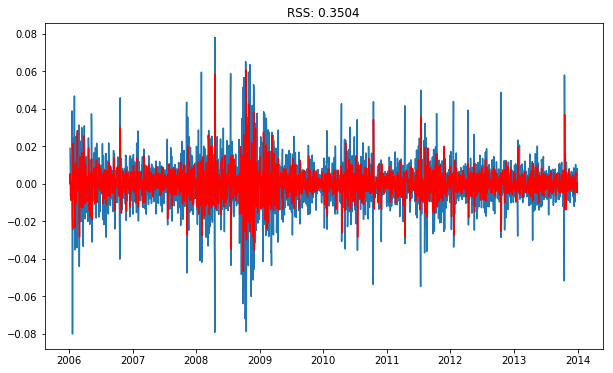

In [34]:
plt.figure(figsize=(10,6))
model = ARIMA(train, order=(9, 0, 0))  
results_AR = model.fit(disp=-1, maxiter=200)  
plt.plot(train)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-train)**2))

## MA model

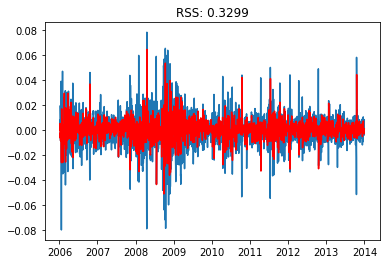

In [35]:
model = ARIMA(train, order=(0, 0, 4))  
results_MA = model.fit(disp=-1, maxiter=200)  
plt.plot(train)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-train)**2))

## combined model

/home/ibtissem/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


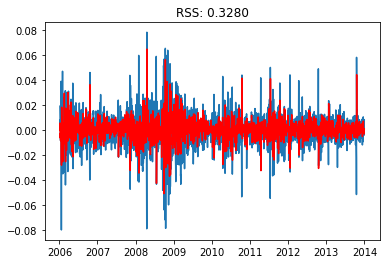

In [36]:
model = ARIMA(train, order=(9, 0, 4))  
results_ARIMA = model.fit(maxiter=200)  
plt.plot(train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-train)**2))

## combined model (choosing the order of the model based on information criteria AIC)

In [ ]:
AIC=np.zeros(78)
ax=[]
for p in range (13):
    for q in range (6):
        mod=ARIMA(cv, order=(p,0,q))
        res=mod.fit(maxiter=500)
        ax.append((p,q))
        AIC[p]=res.aic
plt.plot(range(1,78), AIC[1:-1], marker='o')
plt.xticks(np.arange(1,78),tuple([str(a) for a in ax[1:-1]]))
plt.xlabel('Order of ARMA model')
plt.ylabel('AIC')

## Best model (based on AIC)

In [ ]:
mod = ARMA(cv, order=(9,0))
res = mod.fit(maxiter=200)
print("The AIC for an AR(9) is: ", res.aic)

mod = ARMA(cv, order=(0,4))
res = mod.fit(maxiter=200)
print("The AIC for an MA(4) is: ", res.aic)

mod = ARMA(cv, order=(0,3))
res = mod.fit(maxiter=200)
print("The AIC for an MA(3) is: ", res.aic)

mod = ARMA(cv, order=(2,0))
res = mod.fit(maxiter=200)
print("The AIC for an AR(2) is: ", res.aic)

mod = ARMA(cv, order=(2,3))
res = mod.fit(maxiter=200)
print("The AIC for an ARMA(2,3) is: ", res.aic)

/home/ibtissem/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/ibtissem/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/ibtissem/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/ibtissem/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/home/ibtissem/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/ibtissem/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


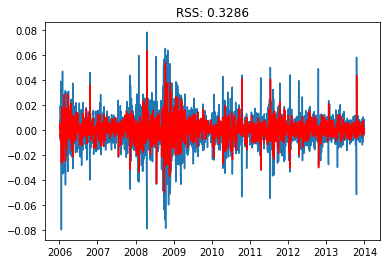

In [37]:
model = ARMA(train, order=(2, 3))  
results_ARIMA = model.fit(maxiter=400)  
plt.plot(train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-train)**2))

In [38]:
predictions_ARIMA_decomp_train = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_decomp_train.head()

Date
2006-01-06   -7.392496e-07
2006-01-07    5.162199e-03
2006-01-08   -1.589584e-03
2006-01-09   -6.450220e-03
2006-01-10   -4.520512e-03
Freq: D, dtype: float64

## Adding seasonality and trend to the train data

In [41]:
predictions_ARIMA_log_train=predictions_ARIMA_decomp_train+seasonal[:len(train)]+trend[:len(train)]

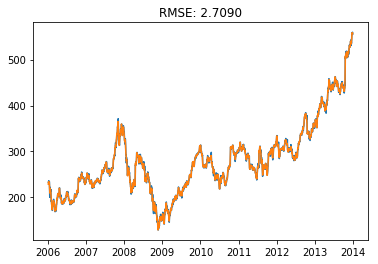

In [43]:
predictions_ARIMA_train = np.exp(predictions_ARIMA_log_train).resample('D').bfill()
predictions_ARIMA_train.dropna(inplace=True)
plt.plot(ts[predictions_ARIMA_train.index])
plt.plot(predictions_ARIMA_train)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_train-ts[predictions_ARIMA_train.index])**2)/len(ts[predictions_ARIMA_train.index])))

In [44]:
pd.concat([predictions_ARIMA_train, ts[predictions_ARIMA_train.index]],axis=1 )

,0,Close
Date,,
2006-01-06,228.712100,233.06
2006-01-07,232.212195,233.68
2006-01-08,232.472137,233.68
2006-01-09,232.159826,233.68
2006-01-10,232.945772,235.11
2006-01-11,233.532369,236.05
2006-01-12,233.311825,232.05
2006-01-13,232.054130,233.36
2006-01-14,232.693649,233.79


## Predicting trend and seasonality of test data

In [45]:
predictions_ARIMA_decomp_test = pd.Series(results_ARIMA.predict(start='2014-01-01', end='2017-12-26'), copy=True)
predictions_ARIMA_decomp_test.head()

2014-01-01    0.002044
2014-01-02   -0.001585
2014-01-03   -0.003674
2014-01-04   -0.001697
2014-01-05   -0.000364
Freq: D, dtype: float64

In [79]:
trend.dropna(inplace=True)

In [105]:
trend_diff=trend[:'2013'][-(predictions_ARIMA_decomp_test.size):].diff(1)

In [106]:
trend_diff_cumsum = trend_diff.cumsum()

In [107]:
trend_diff_cumsum.fillna(0, inplace=True)

In [108]:
predictions_trend_log = np.ones(len(trend_diff))*ts_log["2013-12-31"]

In [109]:
predictions_trend_log = predictions_trend_log+trend_diff_cumsum

In [110]:
ts_log["2013-12-31"]

6.3295782928584501

In [113]:
predictions_ARIMA_log_test=(predictions_ARIMA_decomp_test+seasonal[:'2013'].values[-(predictions_ARIMA_decomp_test.size):]+predictions_trend_log.values).dropna()

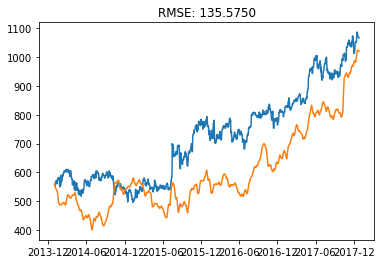

In [114]:
predictions_ARIMA_test = np.exp(predictions_ARIMA_log_test).resample('D').bfill()
predictions_ARIMA_test.dropna(inplace=True)
plt.plot(ts[predictions_ARIMA_test.index])
plt.plot(predictions_ARIMA_test)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_test-ts[predictions_ARIMA_test.index])**2)/len(ts[predictions_ARIMA_test.index])))

In [94]:
pd.concat([predictions_ARIMA_test, ts[predictions_ARIMA_test.index]],axis=1 )

,0,Close
2014-01-01,562.519490,557.12
2014-01-02,556.883510,557.12
2014-01-03,552.554693,553.05
2014-01-04,548.816370,559.22
2014-01-05,546.581326,559.22
2014-01-06,546.054672,559.22
2014-01-07,543.858641,570.00
2014-01-08,542.368014,571.19
2014-01-09,540.338795,565.69
2014-01-10,538.718307,565.66
